In [1]:
__author__ = 'Alysa Obertas'
__email__ = 'obertas@astro.utoronto.ca'

# python systems-predict-stability.py nsys first_sim
#
# predicts stability (for 1e9 orbits) of a 3+ planet system using machine learning
# method developed by Dan Tamayo
#
# finds probability for nsys systems, starting at first_sim
#
# Written by Alysa Obertas (modified from code written by Dan Tamayo)

import numpy as np
import rebound
import matplotlib.pyplot as plt
import matplotlib
import random
import dill
import sys
import pandas as pd
from spock import spockClassifier

try:
    plt.style.use('paper')
except:
    pass

spockoutfile = 'alysa-datafiles/spockprobstesttrio.npz'
megnoprobsoutfile = 'alysa-datafiles/megnoprobstesttrio.npz'
megnosoutfile = 'alysa-datafiles/megnostesttrio.npz'

stride = 20
nsim_list = np.arange(0,17500, stride)

In [2]:
#######################################################################
## read initial condition file

infile_delta_2_to_10 = 'alysa-datafiles/initial_conditions_delta_2_to_10.npz'
infile_delta_10_to_13 = 'alysa-datafiles/initial_conditions_delta_10_to_13.npz'

ic1 = np.load(infile_delta_2_to_10)
ic2 = np.load(infile_delta_10_to_13)

m_star = ic1['m_star'] # mass of star
m_planet = ic1['m_planet'] # mass of planets
rh = (m_planet/3.) ** (1./3.)

Nbody = ic1['Nbody'] # number of planets
year = 2.*np.pi # One year in units where G=1
tf = ic1['tf'] # end time in years

a_init = np.concatenate([ic1['a'], ic2['a']], axis=1) # array containing initial semimajor axis for each delta,planet
f_init = np.concatenate([ic1['f'], ic2['f']], axis=1) # array containing intial longitudinal position for each delta, planet, run

#######################################################################
## create rebound simulation and predict stability for each system in nsim_list

In [3]:
infile_delta_2_to_10 = 'alysa-datafiles/initial_conditions_delta_2_to_10.npz'
infile_delta_10_to_13 = 'alysa-datafiles/initial_conditions_delta_10_to_13.npz'

outfile_nbody_delta_2_to_10 = 'alysa-datafiles/merged_output_files_delta_2_to_10.npz'
outfile_nbody_delta_10_to_13 = 'alysa-datafiles/merged_output_files_delta_10_to_13.npz'

## load hill spacing

ic_delta_2_to_10 = np.load(infile_delta_2_to_10)
ic_delta_10_to_13 = np.load(infile_delta_10_to_13)

delta_2_to_10 = ic_delta_2_to_10['delta']
delta_10_to_13 = ic_delta_10_to_13['delta']

delta = np.hstack((delta_2_to_10, delta_10_to_13))
delta=delta[::stride]

## load rebound simulation first close encounter times

nbody_delta_2_to_10 = np.load(outfile_nbody_delta_2_to_10)
nbody_delta_10_to_13 = np.load(outfile_nbody_delta_10_to_13)

t_exit_delta_2_to_10 = nbody_delta_2_to_10['t_exit']/(0.99)**(3./2)
t_exit_delta_10_to_13 = nbody_delta_10_to_13['t_exit']/(0.99)**(3./2)

t_exit = np.hstack((t_exit_delta_2_to_10, t_exit_delta_10_to_13))
t_exit = t_exit[::stride]

df = pd.DataFrame(np.array([nsim_list, delta, t_exit]).T, columns=['nsim', 'delta', 't_exit'])
df.head()

,nsim,delta,t_exit
0,0.0,2.000573,1.522785
1,20.0,2.015118,9.035188
2,40.0,2.024270,9.695062
3,60.0,2.032864,7.715442
4,80.0,2.041942,1.878101


In [4]:
def init_process():
    global model
    model = spockClassifier()
    
def pred(nsim):
    sim = rebound.Simulation()
    sim.add(m=m_star)
    sim.G = 4*np.pi**2
    for i in range(Nbody): # add the planets
        sim.add(m=m_planet, a=a_init[i,nsim], f=f_init[i,nsim])
    sim.move_to_com()
    sim.integrator="whfast"
    sim.dt = 0.035*sim.particles[1].P
    prob=model.predict(sim)
    return prob

In [5]:
from multiprocessing import Pool
pool = Pool(processes=24, initializer=init_process)

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulation.py:518: RuntimeWarning: WHFast convergence issue. Timestep is larger than at least one orbital period.
  warnings.warn(msg[1:], RuntimeWarning)
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeW

In [6]:
%%time
res = pool.map(pred, nsim_list)

CPU times: user 243 ms, sys: 81.7 ms, total: 325 ms
Wall time: 2min 58s


In [7]:
np.savez(spockoutfile, nsim_list=nsim_list, probs=np.array(res))

In [8]:
infile_delta_2_to_10 = 'alysa-datafiles/initial_conditions_delta_2_to_10.npz'
infile_delta_10_to_13 = 'alysa-datafiles/initial_conditions_delta_10_to_13.npz'

outfile_nbody_delta_2_to_10 = 'alysa-datafiles/merged_output_files_delta_2_to_10.npz'
outfile_nbody_delta_10_to_13 = 'alysa-datafiles/merged_output_files_delta_10_to_13.npz'

spockoutfile_ml_probs = 'alysa-datafiles/stability-probs-sims-spockalltrios.npz'

## load hill spacing

ic_delta_2_to_10 = np.load(infile_delta_2_to_10)
ic_delta_10_to_13 = np.load(infile_delta_10_to_13)

delta_2_to_10 = ic_delta_2_to_10['delta']
delta_10_to_13 = ic_delta_10_to_13['delta']

delta = np.hstack((delta_2_to_10, delta_10_to_13))
delta=delta[::stride]

## load rebound simulation first close encounter times

nbody_delta_2_to_10 = np.load(outfile_nbody_delta_2_to_10)
nbody_delta_10_to_13 = np.load(outfile_nbody_delta_10_to_13)

t_exit_delta_2_to_10 = nbody_delta_2_to_10['t_exit']/(0.99)**(3./2)
t_exit_delta_10_to_13 = nbody_delta_10_to_13['t_exit']/(0.99)**(3./2)

t_exit = np.hstack((t_exit_delta_2_to_10, t_exit_delta_10_to_13))
t_exit = t_exit[::stride]

log_t_exit = np.log10(t_exit)
survival_1e9 = log_t_exit >= 9

survival_true = survival_1e9 == True
survival_false = survival_1e9 == False

## load machine learning stability probabilities

spockml_data = np.load(spockoutfile)
spockprobs = spockml_data['probs']

delta.shape

(875,)

#  TPR

In [9]:
thresh = 0.49
(spockprobs[survival_true] > thresh).sum()/survival_true.sum()

0.9541284403669725

# FPR

In [10]:
(spockprobs[survival_false] > thresh).sum()/survival_false.sum()

0.0783289817232376

In [11]:
survival_false.sum()

766

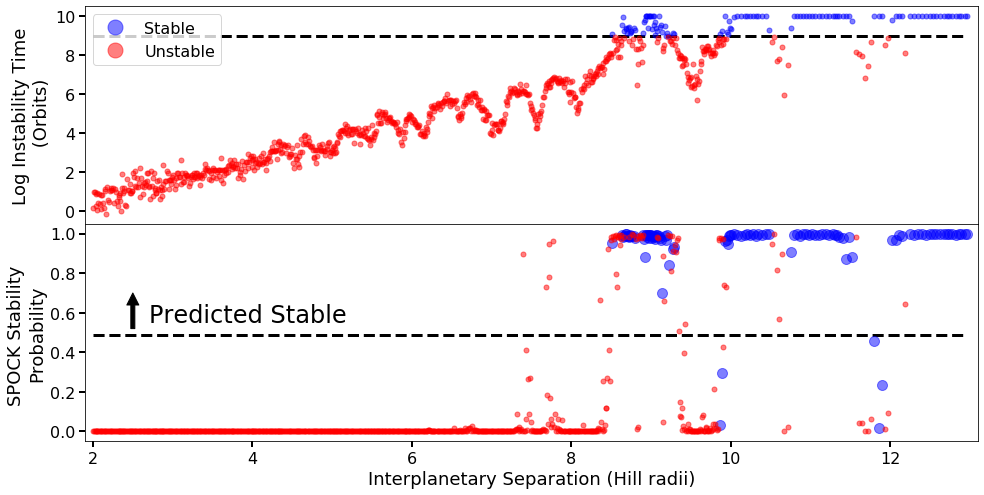

In [13]:
## plot delta vs prob

fig, ax = plt.subplots(2, 1, figsize=(16,8), sharex=True)
plt.subplots_adjust(hspace=0, wspace=0)

# scatter

ms=5

ax[0].plot([np.min(delta), np.max(delta)], [9,9], '--k')
ax[0].plot(delta[survival_true],log_t_exit[survival_true],'ob', alpha=0.5, markersize=ms,rasterized=True,label='Stable')
ax[0].plot(delta[survival_false],log_t_exit[survival_false],'or', alpha=0.5, markersize=ms,rasterized=True,label='Unstable')

ax[1].plot([np.min(delta), np.max(delta)], [0.49,0.49], '--k')
ax[1].plot(delta[survival_true], spockprobs[survival_true],'ob', alpha=0.5, markersize=ms*2,rasterized=True)
ax[1].plot(delta[survival_false], spockprobs[survival_false],'or', alpha=0.5, markersize=ms, rasterized=True)

ax[1].annotate("", xy=(2.5, 0.7), xytext=(2.5, 0.52), arrowprops=dict(facecolor='black'))
ax[1].text(2.7, 0.55, "Predicted Stable", fontsize=24)

ax[1].set_xlabel("Interplanetary Separation (Hill radii)", fontsize=18)
ax[1].set_xlim([1.9, 13.1])

ax[1].set_ylabel("SPOCK Stability \nProbability", fontsize=18)
ax[0].set_ylabel("Log Instability Time\n (Orbits)", fontsize=18)

ax[0].legend(loc=2, markerscale=3)
plt.savefig('alysa.pdf',bbox_inches='tight')